# ML modelling ใช้ ensemble 2 ตัว กับ ZR 3 แบบ threshold rain > 0
* ทดสอบ 2 แบบจำลอง ได้แก่ RandomForestRegressor, GradientBoostingRegressor
* ประเมินด้วยสถิติ RMSE, MSE, MAE, MFB, Correlation Coefficient, R2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform, randint, linregress

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform

import geopandas as gpd

warnings.filterwarnings('ignore')



In [2]:
df = pd.read_csv('../2results/df_org_dbz_rain_inbasin_120km.csv')

In [3]:
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True)

,cappi1km,cappi2km,cappi3km,cappi4km,full_date,code,rain_x
0,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
1,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
2,35.427362,33.911951,33.814425,34.668089,2018-06-01-03:00,CMSG,0.2
3,31.115211,31.477566,32.408463,33.207074,2018-06-01-04:00,CMSG,3.4
4,29.090362,29.558125,30.479992,31.064178,2018-06-01-04:00,NAN008,9.4
...,...,...,...,...,...,...,...
1701,35.262646,33.105425,30.091339,28.621504,2018-09-20-16:00,NMPR,2.2
1702,22.052814,24.789279,27.074918,27.700281,2018-09-20-16:00,TGSK,0.8
1703,21.603189,23.323372,24.247740,25.084608,2018-09-20-17:00,TGSK,0.2
1704,31.854776,31.898127,31.546525,29.810020,2018-09-21-14:00,PIN003,2.4


In [4]:
df.drop(columns=['cappi1km','cappi3km','cappi4km'], inplace=True) #ลบคอลัน์

In [5]:
df.rename(columns={"cappi2km": "dBZ_c2"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c2,full_date,code,rain_truth
52,22.656334,2018-06-01-01:00,CMSG,0.4
100,28.025389,2018-06-01-02:00,CMSG,0.2
144,33.911951,2018-06-01-03:00,CMSG,0.2
197,31.477566,2018-06-01-04:00,CMSG,3.4
211,29.558125,2018-06-01-04:00,NAN008,9.4
...,...,...,...,...
49473,33.105425,2018-09-20-16:00,NMPR,2.2
49489,24.789279,2018-09-20-16:00,TGSK,0.8
49545,23.323372,2018-09-20-17:00,TGSK,0.2
50610,31.898127,2018-09-21-14:00,PIN003,2.4


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [6]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c2']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [7]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c2'], inplace=True) #ลบคอลัน์

In [8]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,full_date,code,rain_truth,rr_MP_c2,rr_RF_c2,rr_SC_c2
0,2018-06-01-01:00,CMSG,0.4,0.950336,0.775791,0.706216
1,2018-06-01-02:00,CMSG,0.2,2.057989,2.173530,1.707816
2,2018-06-01-03:00,CMSG,0.2,4.801238,6.725314,4.496865
3,2018-06-01-04:00,CMSG,3.4,3.382238,4.215481,3.013181
4,2018-06-01-04:00,NAN008,9.4,2.565896,2.916713,2.197467
...,...,...,...,...,...,...
1701,2018-09-20-16:00,NMPR,2.2,4.275090,5.761056,3.938228
1702,2018-09-20-16:00,TGSK,0.8,1.291773,1.168127,1.002976
1703,2018-09-20-17:00,TGSK,0.2,1.046085,0.881721,0.788103
1704,2018-09-21-14:00,PIN003,2.4,3.593265,4.569766,3.228980


## รวมเป็นฝนรายวัน

In [9]:
# Extract date from 'full_date' column
df['date_only'] = pd.to_datetime(df['full_date']).dt.date

# Group by 'date_only' and 'code', then sum the 'rain_truth' values
aggregated_data = df.groupby(['date_only', 'code']).sum().reset_index()

# replace NaN with 0 after aggregation using fillna(0)
#aggregated_data.fillna(0, inplace=True)

aggregated_data.dropna(inplace=True)
aggregated_data.reset_index(drop=True)

aggregated_data.head()

,date_only,code,rain_truth,rr_MP_c2,rr_RF_c2,rr_SC_c2
0,2018-06-01,CMSG,4.8,12.901962,15.588196,11.306208
1,2018-06-01,KOKO,19.4,2.936022,3.010823,2.396904
2,2018-06-01,LMKO,16.2,4.245238,4.726619,3.595372
3,2018-06-01,NAN008,10.2,3.993997,4.252037,3.322299
4,2018-06-01,PIN003,11.2,10.342934,18.711130,10.809694


In [10]:
# conditional rain
df_=aggregated_data[aggregated_data['rain_truth']>0]
#df_=df_[df_['rr_SC_c1']>0]
df_.reset_index(drop=True, inplace=True)
df_.describe()
df=df_

# Model ZR MP

## เตรียมข้อมูล ZR_MP

In [11]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_MP_c2']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 445 rows
Test Set: 191 rows


## สถิติประเมินแบบจำลอง

In [12]:
def cal_metrics(x, y):    
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    mfb = x.sum(axis=0) / y.sum(axis=0)
    
    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    return {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "MFB": mfb,
        "Correlation coefficient (r)": r_value,
        "P-value": p_value
    }

## ทดสอบกับ GradientBoostingRegressor

In [13]:


# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor_ZR_MP = grid_search.best_estimator_
print(best_model_GradientBoostingRegressor_ZR_MP, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor_ZR_MP.predict(X_test)


Best parameter combination: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=4,
                          n_estimators=200, subsample=0.8) 



In [14]:
print(cal_metrics(y_test.flatten(),predictions_GradientBoostingRegressor))

{'RMSE': 7.038874297645543, 'MSE': 49.54575137805503, 'MAE': 4.841655384200591, 'R-squared': 0.13780414622582704, 'MFB': 0.8672644794322981, 'Correlation coefficient (r)': 0.5346786306447727, 'P-value': 1.6249563829676306e-15}


## ทดสอบกับ RandomForest

In [15]:
# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_RandomForestRegressor_ZR_MP = grid_search.best_estimator_
print(best_model_RandomForestRegressor_ZR_MP, "\n")

# Evaluate the model using the test data
predictions_RandomForestRegressor = best_model_RandomForestRegressor_ZR_MP.predict(X_test)



Best parameter combination: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150} 

RandomForestRegressor(max_depth=3, min_samples_leaf=4, n_estimators=150) 



In [16]:
before_adjust_RF_ZR_MP=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_RF_ZR_MP=np.sum(y_test.flatten())/np.sum(best_model_RandomForestRegressor_ZR_MP.predict(X_test).flatten())

before_adjust_GB_ZR_MP=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_GB_ZR_MP=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor_ZR_MP.predict(X_test).flatten())

## ประเมินแบบจำลองจากค่าสถิติ

In [17]:
# Evaluate the models using the test data
predictions = {
    "GradientBoostingRegressor": best_model_GradientBoostingRegressor_ZR_MP.predict(X_test),
    "RandomForestRegressor": best_model_RandomForestRegressor_ZR_MP.predict(X_test)
}

# Calculate metrics for each model
metrics = {}
for model_name, prediction in predictions.items():
    metrics[model_name] = cal_metrics(y_test.flatten(), prediction.flatten())

# Create DataFrames from metrics dictionaries
dfs = []
for model_name, metric in metrics.items():
    dfs.append(pd.DataFrame(metric, index=[0]))

# Concatenate DataFrames along the rows
results_df = pd.concat(dfs, ignore_index=True)

# Add Model names
results_df['Model'] = list(predictions.keys())

# Set the display format to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Print the results
print(results_df)
results_df

   RMSE    MSE   MAE  R-squared   MFB  Correlation coefficient (r)  P-value  \
0 7.039 49.546 4.842      0.138 0.867                        0.535    0.000   
1 7.376 54.401 4.762      0.053 0.853                        0.547    0.000   

                       Model  
0  GradientBoostingRegressor  
1      RandomForestRegressor  


,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value,Model
0,7.039,49.546,4.842,0.138,0.867,0.535,0.000,GradientBoostingRegressor
1,7.376,54.401,4.762,0.053,0.853,0.547,0.000,RandomForestRegressor


## density plot

In [18]:
def density_plot(rain_truth, rain_radar, max_=15):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    

    font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

    plt.rc('font', **font)

    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0.005  # specify your minimum value
    cbar_max = 0.009 # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=40, cmap='rainbow', alpha=0.6, vmin=cbar_min, vmax=cbar_max)

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='--', color='grey', linewidth=2)

    # Set font size for axis labels and title
    plt.xlabel('predicted radar rainfall based on model [mm/day]')
    plt.ylabel('gauge rainfall [mm/day]')
    plt.title('Comparison daily radar and gauge rainfall', fontsize=16)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=14)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot the regression line
    #plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
    #         label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    
    # Set font size for legend
    plt.legend(fontsize=12)

    # Display the plot
    plt.show()
    
    print(slope, intercept)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


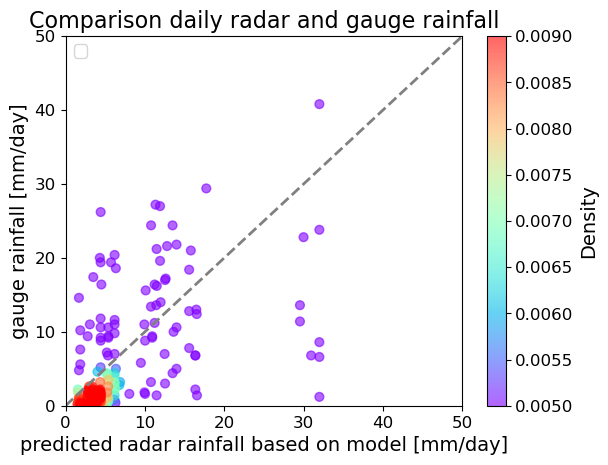

0.5946165281974425 1.9198390583946594


In [19]:
density_plot(y_test.flatten(),best_model_GradientBoostingRegressor_ZR_MP.predict(X_test).flatten(), 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


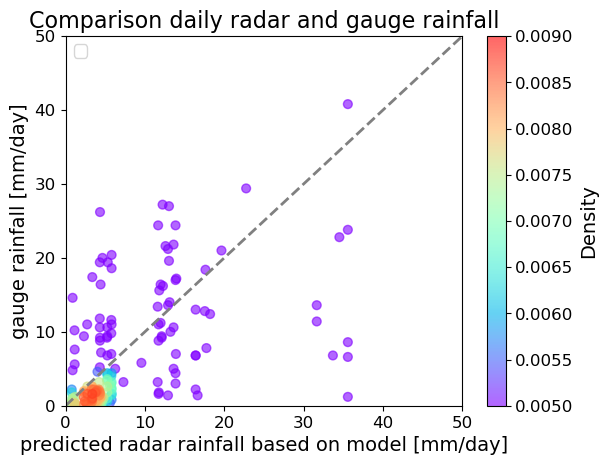

0.5346793246305571 2.2773664997608196


In [20]:
density_plot(y_test.flatten(),best_model_RandomForestRegressor_ZR_MP.predict(X_test).flatten(), 50)

# Model ZR RF

## เตรียมข้อมูล ZR_RF

In [21]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_RF_c2']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 445 rows
Test Set: 191 rows


## ทดสอบกับ GradientBoostingRegressor

In [22]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor_ZR_RF = grid_search.best_estimator_
print(best_model_GradientBoostingRegressor_ZR_RF, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor_ZR_RF.predict(X_test)

Best parameter combination: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=4,
                          n_estimators=200, subsample=0.8) 



## ทดสอบกับ RandomForest

In [23]:
# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_RandomForestRegressor_ZR_RF = grid_search.best_estimator_
print(best_model_RandomForestRegressor_ZR_RF, "\n")

# Evaluate the model using the test data
predictions_RandomForestRegressor = best_model_RandomForestRegressor_ZR_RF.predict(X_test)


Best parameter combination: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 

RandomForestRegressor(max_depth=3, min_samples_leaf=4) 



In [24]:
before_adjust_RF_ZR_RF=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_RF_ZR_RF=np.sum(y_test.flatten())/np.sum(best_model_RandomForestRegressor_ZR_RF.predict(X_test).flatten())

before_adjust_GB_ZR_RF=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_GB_ZR_RF=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor_ZR_RF.predict(X_test).flatten())

## ประเมินแบบจำลองจากค่าสถิติ

In [25]:
# Evaluate the models using the test data
predictions = {
    "GradientBoostingRegressor": best_model_GradientBoostingRegressor_ZR_RF.predict(X_test),
    "RandomForestRegressor": best_model_RandomForestRegressor_ZR_RF.predict(X_test)
}

# Calculate metrics for each model
metrics = {}
for model_name, prediction in predictions.items():
    metrics[model_name] = cal_metrics(y_test.flatten(), prediction.flatten())

# Create DataFrames from metrics dictionaries
dfs = []
for model_name, metric in metrics.items():
    dfs.append(pd.DataFrame(metric, index=[0]))

# Concatenate DataFrames along the rows
results_df = pd.concat(dfs, ignore_index=True)

# Add Model names
results_df['Model'] = list(predictions.keys())

# Set the display format to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Print the results
print(results_df)
results_df

   RMSE    MSE   MAE  R-squared   MFB  Correlation coefficient (r)  P-value  \
0 7.099 50.402 4.863      0.123 0.825                        0.538    0.000   
1 7.586 57.542 4.887     -0.001 0.808                        0.539    0.000   

                       Model  
0  GradientBoostingRegressor  
1      RandomForestRegressor  


,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value,Model
0,7.099,50.402,4.863,0.123,0.825,0.538,0.000,GradientBoostingRegressor
1,7.586,57.542,4.887,-0.001,0.808,0.539,0.000,RandomForestRegressor


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


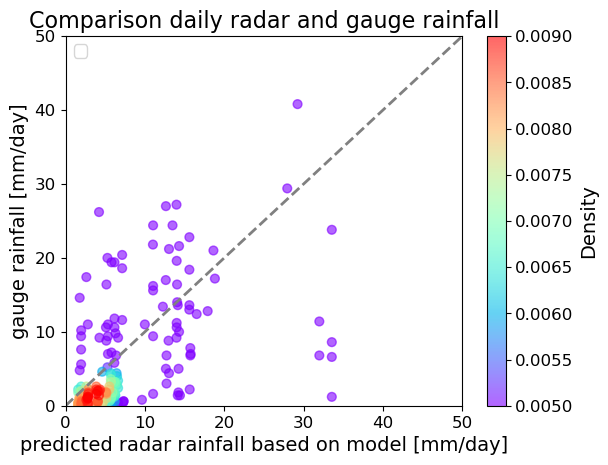

0.5925370008808573 1.718148048144922


In [26]:
density_plot(y_test.flatten(),best_model_GradientBoostingRegressor_ZR_RF.predict(X_test).flatten(), 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


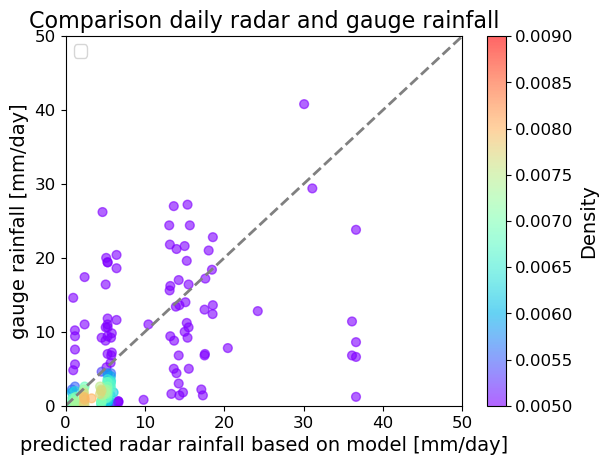

0.5161301834047939 2.2069731538727773


In [27]:
density_plot(y_test.flatten(),best_model_RandomForestRegressor_ZR_RF.predict(X_test).flatten(), 50)

# Model ZR SC

## เตรียมข้อมูล ZR_SC

In [28]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_SC_c2']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 445 rows
Test Set: 191 rows


## ทดสอบกับ GradientBoostingRegressor

In [29]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor_ZR_SC = grid_search.best_estimator_
print(best_model_GradientBoostingRegressor_ZR_SC, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor_ZR_SC.predict(X_test)

Best parameter combination: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=4,
                          min_samples_split=10, n_estimators=200,
                          subsample=0.8) 



## ทดสอบกับ RandomForest

In [30]:
# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
grid_search = GridSearchCV(alg, params, scoring=score, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best parameter combination:", grid_search.best_params_, "\n")

# Get the best model
best_model_RandomForestRegressor_ZR_SC = grid_search.best_estimator_
print(best_model_RandomForestRegressor_ZR_SC, "\n")

# Evaluate the model using the test data
predictions_RandomForestRegressor = best_model_RandomForestRegressor_ZR_SC.predict(X_test)


Best parameter combination: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150} 

RandomForestRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=150) 



In [31]:
before_adjust_RF_ZR_SC=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_RF_ZR_SC=np.sum(y_test.flatten())/np.sum(best_model_RandomForestRegressor_ZR_SC.predict(X_test).flatten())

before_adjust_GB_ZR_SC=np.sum(y_test.flatten())/np.sum(X_test[:].flatten())
after_adjust_GB_ZR_SC=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor_ZR_SC.predict(X_test).flatten())

## ประเมินแบบจำลองจากค่าสถิติ

In [32]:
# Evaluate the models using the test data
predictions = {
    "GradientBoostingRegressor": best_model_GradientBoostingRegressor_ZR_SC.predict(X_test),
    "RandomForestRegressor": best_model_RandomForestRegressor_ZR_SC.predict(X_test)
}

# Calculate metrics for each model
metrics = {}
for model_name, prediction in predictions.items():
    metrics[model_name] = cal_metrics(y_test.flatten(), prediction.flatten())

# Create DataFrames from metrics dictionaries
dfs = []
for model_name, metric in metrics.items():
    dfs.append(pd.DataFrame(metric, index=[0]))

# Concatenate DataFrames along the rows
results_df = pd.concat(dfs, ignore_index=True)

# Add Model names
results_df['Model'] = list(predictions.keys())

# Set the display format to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Print the results
print(results_df)
results_df

   RMSE    MSE   MAE  R-squared   MFB  Correlation coefficient (r)  P-value  \
0 7.188 51.666 4.862      0.101 0.834                        0.551    0.000   
1 7.567 57.255 4.840      0.004 0.824                        0.555    0.000   

                       Model  
0  GradientBoostingRegressor  
1      RandomForestRegressor  


,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value,Model
0,7.188,51.666,4.862,0.101,0.834,0.551,0.000,GradientBoostingRegressor
1,7.567,57.255,4.840,0.004,0.824,0.555,0.000,RandomForestRegressor


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


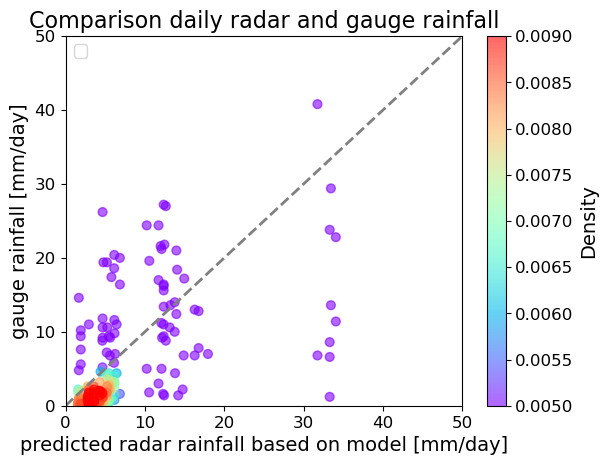

0.5669610808250153 1.9554771745271946


In [33]:
density_plot(y_test.flatten(),best_model_GradientBoostingRegressor_ZR_SC.predict(X_test).flatten(), 50)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


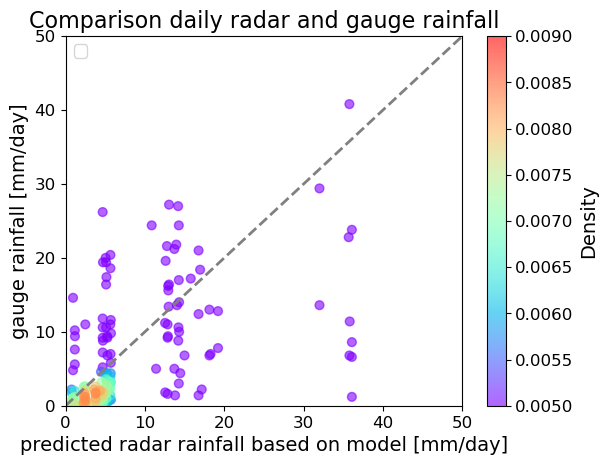

0.5142820734995612 2.2955694788969


In [34]:
density_plot(y_test.flatten(),best_model_RandomForestRegressor_ZR_SC.predict(X_test).flatten(), 50)

# พลอตกราฟเปรียบเทียบ MFB ของแต่ละแบบจำลอง ก่อนและหลังการใช้ Models

In [35]:
print(before_adjust_RF_ZR_MP)
print(after_adjust_RF_ZR_MP)
print(before_adjust_GB_ZR_MP)
print(after_adjust_GB_ZR_MP)

print('\n')

print(before_adjust_RF_ZR_RF)
print(after_adjust_RF_ZR_RF)
print(before_adjust_GB_ZR_RF)
print(after_adjust_GB_ZR_RF)
print('\n')

print(before_adjust_RF_ZR_SC)
print(after_adjust_RF_ZR_SC)
print(before_adjust_GB_ZR_SC)
print(after_adjust_GB_ZR_SC)



0.9976199848825671
0.852652932009397
0.9976199848825671
0.8672644794322981


0.6483743889569351
0.8082158755466493
0.6483743889569351
0.8245136637013742


1.0450854541813939
0.8240424720883818
1.0450854541813939
0.8340272236200766


In [36]:
# คำนวณเปอร์เซ็นต์การปรับแก้
pc_RF_ZR_MP=((before_adjust_RF_ZR_MP-after_adjust_RF_ZR_MP)/before_adjust_RF_ZR_MP)*100
pc_RF_ZR_RF=((before_adjust_RF_ZR_RF-after_adjust_RF_ZR_RF)/before_adjust_RF_ZR_RF)*100
pc_RF_ZR_SC=((before_adjust_RF_ZR_SC-after_adjust_RF_ZR_SC)/before_adjust_RF_ZR_SC)*100
print(pc_RF_ZR_MP)
print(pc_RF_ZR_RF)
print(pc_RF_ZR_SC)
print('\n')

pc_GB_ZR_MP=((before_adjust_GB_ZR_MP-after_adjust_GB_ZR_MP)/before_adjust_GB_ZR_MP)*100
pc_GB_ZR_RF=((before_adjust_GB_ZR_RF-after_adjust_GB_ZR_RF)/before_adjust_GB_ZR_RF)*100
pc_GB_ZR_SC=((before_adjust_GB_ZR_SC-after_adjust_GB_ZR_SC)/before_adjust_GB_ZR_SC)*100
print(pc_GB_ZR_MP)
print(pc_GB_ZR_RF)
print(pc_GB_ZR_SC)


14.531289977138403
-24.65265274386568
21.150708892619036


13.066649368057067
-27.16629122686372
20.19530840438663


In [43]:
# คำนวณเปอร์เซ็นต์การปรับแก้
pc_RF_ZR_MP=((before_adjust_RF_ZR_MP-after_adjust_RF_ZR_MP)/1.0)*100
pc_RF_ZR_RF=((before_adjust_RF_ZR_RF-after_adjust_RF_ZR_RF)/1.0)*100
pc_RF_ZR_SC=((before_adjust_RF_ZR_SC-after_adjust_RF_ZR_SC)/1.0)*100
print(pc_RF_ZR_MP)
print(pc_RF_ZR_RF)
print(pc_RF_ZR_SC)
print('\n')

pc_GB_ZR_MP=((before_adjust_GB_ZR_MP-after_adjust_GB_ZR_MP)/1.0)*100
pc_GB_ZR_RF=((before_adjust_GB_ZR_RF-after_adjust_GB_ZR_RF)/1.0)*100
pc_GB_ZR_SC=((before_adjust_GB_ZR_SC-after_adjust_GB_ZR_SC)/1.0)*100
print(pc_GB_ZR_MP)
print(pc_GB_ZR_RF)
print(pc_GB_ZR_SC)

14.496705287317013
-15.98414865897142
22.10429820930121


13.035550545026897
-17.613927474443912
21.105823056131722


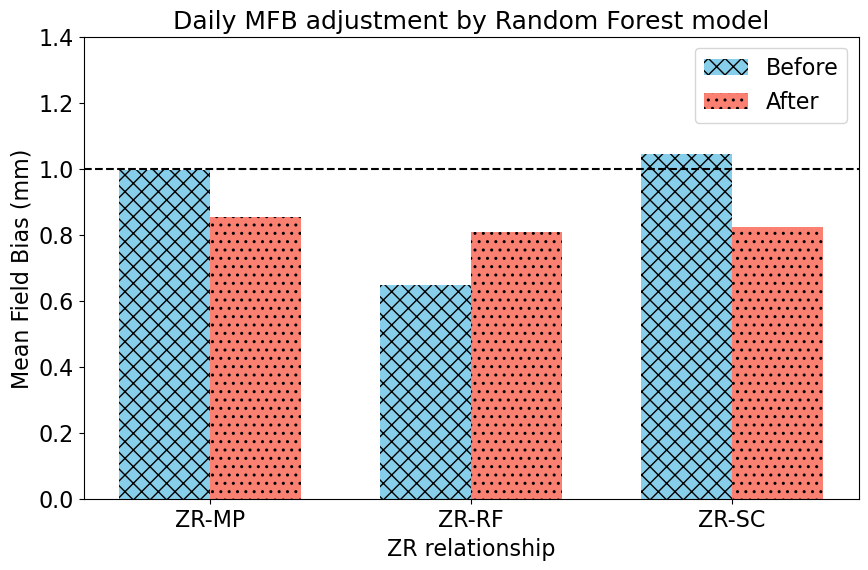

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = np.array([[before_adjust_RF_ZR_MP, after_adjust_RF_ZR_MP], 
                   [before_adjust_RF_ZR_RF, after_adjust_RF_ZR_RF], 
                   [before_adjust_RF_ZR_SC, after_adjust_RF_ZR_SC]])
labels = ['ZR-MP', 'ZR-RF', 'ZR-SC']
before_values = values[:, 0]
after_values = values[:, 1]

# Enlarge the figure plot
plt.figure(figsize=(10, 6))  

# Plot
bar_width = 0.35
index = np.arange(len(labels))
plt.bar(index, before_values, bar_width, label='Before', color='skyblue',hatch='xx')  
plt.bar(index + bar_width, after_values, bar_width, label='After', color='salmon',hatch='..')  

plt.ylim(0, 1.4)
plt.axhline(y=1.0, color='black', linestyle='--')

plt.xlabel('ZR relationship', fontsize=16)  
plt.ylabel('Mean Field Bias (mm)', fontsize=16) 
plt.title('Daily MFB adjustment by Random Forest model', fontsize=18)  
plt.xticks(index + bar_width / 2, labels, fontsize=16)  
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)  

plt.show()

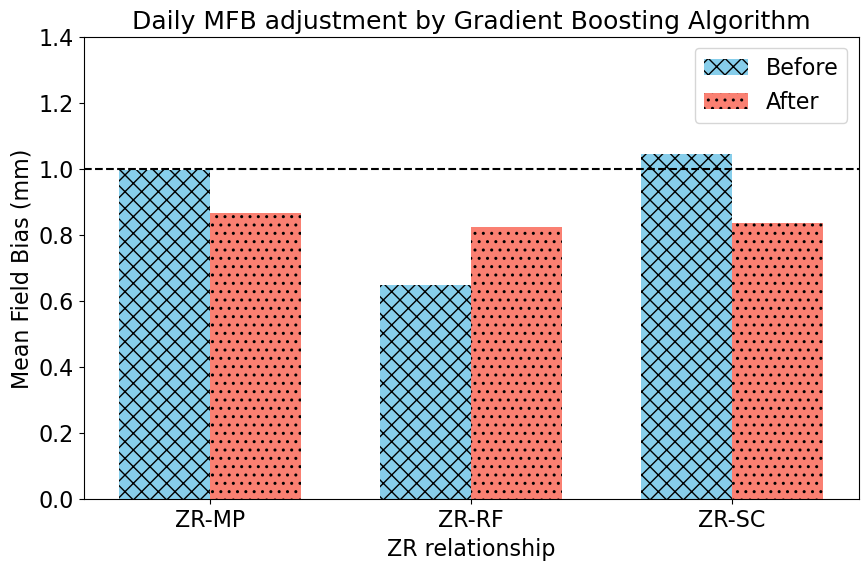

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = np.array([[before_adjust_GB_ZR_MP, after_adjust_GB_ZR_MP], 
                   [before_adjust_GB_ZR_RF, after_adjust_GB_ZR_RF], 
                   [before_adjust_GB_ZR_SC, after_adjust_GB_ZR_SC]])
labels = ['ZR-MP', 'ZR-RF', 'ZR-SC']
before_values = values[:, 0]
after_values = values[:, 1]

# Enlarge the figure plot
plt.figure(figsize=(10, 6))  

# Plot
bar_width = 0.35
index = np.arange(len(labels))
plt.bar(index, before_values, bar_width, label='Before', color='skyblue',hatch='xx')  
plt.bar(index + bar_width, after_values, bar_width, label='After', color='salmon',hatch='..')  

plt.ylim(0, 1.4)
plt.axhline(y=1.0, color='black', linestyle='--')

plt.xlabel('ZR relationship', fontsize=16)  
plt.ylabel('Mean Field Bias (mm)', fontsize=16) 
plt.title('Daily MFB adjustment by Gradient Boosting Algorithm', fontsize=18)  
plt.xticks(index + bar_width / 2, labels, fontsize=16)  
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)  

plt.show()

In [39]:
before_adjust_GB_ZR_MP

0.9976199848825671

In [40]:
after_adjust_RF_ZR_MP

0.852652932009397

In [41]:
after_adjust_GB_ZR_MP

0.8672644794322981

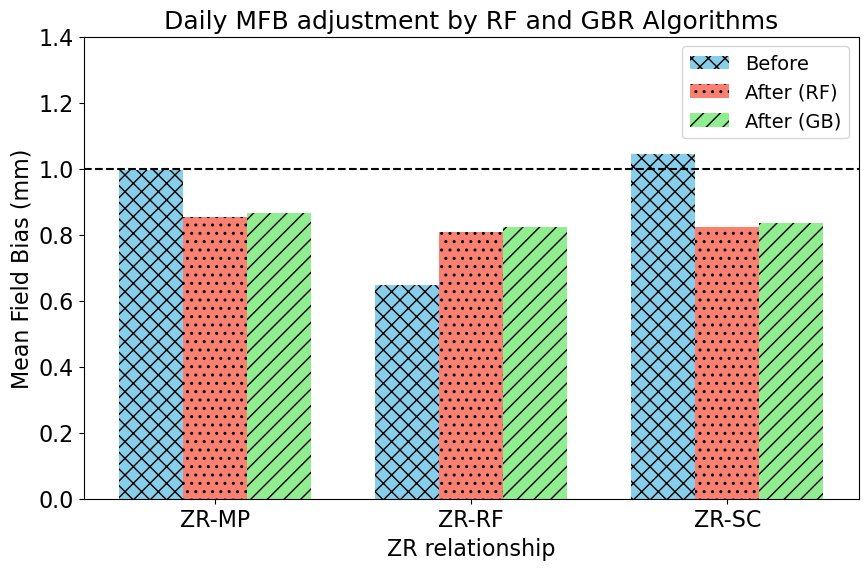

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = np.array([[before_adjust_GB_ZR_MP, after_adjust_RF_ZR_MP, after_adjust_GB_ZR_MP], 
                   [before_adjust_GB_ZR_RF, after_adjust_RF_ZR_RF, after_adjust_GB_ZR_RF], 
                   [before_adjust_GB_ZR_SC, after_adjust_RF_ZR_SC, after_adjust_GB_ZR_SC]])
labels = ['ZR-MP', 'ZR-RF', 'ZR-SC']
before_values = values[:, 0]
after_RF_values = values[:, 1]
after_GB_values = values[:, 2]

# Enlarge the figure plot
plt.figure(figsize=(10, 6))

# Plot
bar_width = 0.25
index = np.arange(len(labels))
plt.bar(index, before_values, bar_width, label='Before', color='skyblue', hatch='xx')  
plt.bar(index + bar_width, after_RF_values, bar_width, label='After (RF)', color='salmon', hatch='..')  
plt.bar(index + 2*bar_width, after_GB_values, bar_width, label='After (GB)', color='lightgreen', hatch='//')

plt.ylim(0, 1.4)
plt.axhline(y=1.0, color='black', linestyle='--')

plt.xlabel('ZR relationship', fontsize=16)  
plt.ylabel('Mean Field Bias (mm)', fontsize=16) 
plt.title('Daily MFB adjustment by RF and GBR Algorithms', fontsize=18)  
plt.xticks(index + bar_width, labels, fontsize=16)  
plt.yticks(fontsize=16) 
plt.legend(fontsize=14)  

plt.show()
